<a href="https://colab.research.google.com/github/caguirre5/Lab9-DL/blob/main/lab09_time_series_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

In [95]:
data = pd.read_csv('https://drive.google.com/uc?id=16w8ahgJvh1uQifglFatoI05UjLcLDcoO')
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


<bound method NDFrame.head of              date  store  sales
0      2013-01-01      1   1316
1      2013-01-01      2   1742
2      2013-01-01      3   1588
3      2013-01-01      4   1423
4      2013-01-01      5   1032
...           ...    ...    ...
18255  2017-12-31      6   2009
18256  2017-12-31      7   1831
18257  2017-12-31      8   3205
18258  2017-12-31      9   2774
18259  2017-12-31     10   2939

[18260 rows x 3 columns]>

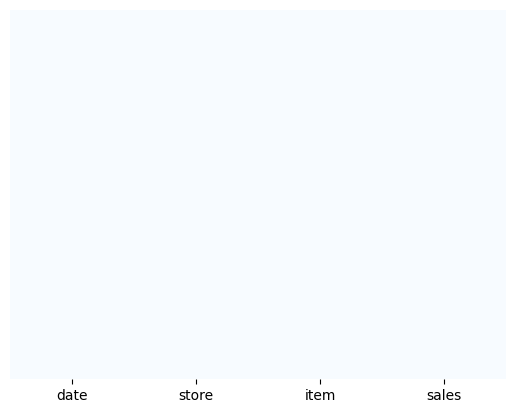

In [96]:
sns.heatmap(data.isnull(), yticklabels = False, cbar = False, cmap="Blues")
data.isnull().sum()
# Elimina la columna 'item'
data = data.drop(columns=['item'])

# Agrupa por 'date' y 'store' y suma las ventas
data = data.groupby(['date', 'store']).sum().reset_index()

data.head

In [97]:
data.columns

Index(['date', 'store', 'sales'], dtype='object')

date
2013-01-01    1316
2013-01-02    1264
2013-01-03    1305
2013-01-04    1452
2013-01-05    1499
Name: sales, dtype: int64

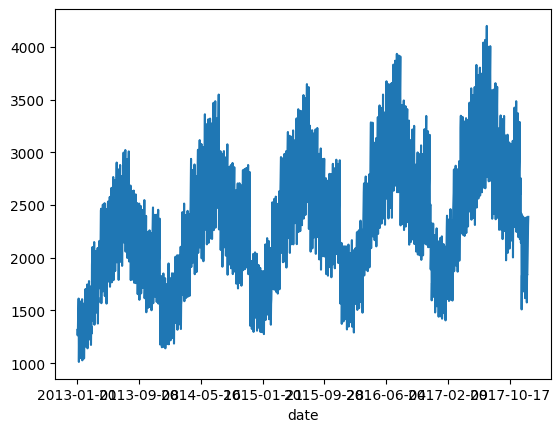

In [98]:
# univariate dataframe: sales vs Time
store_1_data = data[data['store'] == 1]
uni_data_data = store_1_data['sales']
uni_data_data.index = store_1_data['date']
uni_data_data.plot()
uni_data_data.head()

In [99]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler  # Agrega esta línea para importar StandardScaler


# Supongamos que 'data' es tu DataFrame original con datos de ventas.
# Asegúrate de que la columna 'date' esté en formato de fecha.
data['date'] = pd.to_datetime(data['date'])

# Divide los datos en conjuntos de entrenamiento, validación y prueba
fecha_fin_prueba = data['date'].max()
fecha_inicio_prueba = fecha_fin_prueba - pd.DateOffset(months=3)
fecha_inicio_validacion = fecha_inicio_prueba - pd.DateOffset(months=6)

conjunto_entrenamiento = data[(data['date'] < fecha_inicio_validacion)]
conjunto_validacion = data[(data['date'] >= fecha_inicio_validacion) & (data['date'] < fecha_inicio_prueba)]
conjunto_prueba = data[(data['date'] >= fecha_inicio_prueba) & (data['date'] <= fecha_fin_prueba)]

# Escala los datos de ventas para tener una media de 0 y desviación estándar de 1
scaler = StandardScaler()
conjunto_entrenamiento['sales'] = scaler.fit_transform(conjunto_entrenamiento['sales'].values.reshape(-1, 1))
conjunto_validacion['sales'] = scaler.transform(conjunto_validacion['sales'].values.reshape(-1, 1))
conjunto_prueba['sales'] = scaler.transform(conjunto_prueba['sales'].values.reshape(-1, 1))

# Genera secuencias para el conjunto de entrenamiento y validación
def generar_secuencias(datos, ventana_historica):
    secuencias = []
    for i in range(len(datos) - ventana_historica - 90):  # 90 días para pronosticar 3 meses
        secuencia = datos[i:i+ventana_historica]
        objetivo = datos[i+ventana_historica:i+ventana_historica+90]
        secuencias.append((secuencia, objetivo))
    return secuencias

ventana_historica = 90  # Por ejemplo, una ventana de 90 días para datos diarios.
secuencias_entrenamiento = generar_secuencias(conjunto_entrenamiento['sales'].values, ventana_historica)
secuencias_validacion = generar_secuencias(conjunto_validacion['sales'].values, ventana_historica)
secuencias_prueba = generar_secuencias(conjunto_prueba['sales'].values, ventana_historica)

# Convierte las secuencias en matrices NumPy
X_entrenamiento, y_entrenamiento = zip(*secuencias_entrenamiento)
X_validacion, y_validacion = zip(*secuencias_validacion)
X_prueba, y_prueba = zip(*secuencias_prueba)

X_entrenamiento = np.array(X_entrenamiento).reshape(len(X_entrenamiento), ventana_historica, 1)
y_entrenamiento = np.array(y_entrenamiento)
X_validacion = np.array(X_validacion).reshape(len(X_validacion), ventana_historica, 1)
y_validacion = np.array(y_validacion)
X_prueba = np.array(X_prueba).reshape(len(X_prueba), ventana_historica, 1)
y_prueba = np.array(y_prueba)

# Define el modelo
modelo = Sequential()
modelo.add(LSTM(units=64, input_shape=(ventana_historica, 1), return_sequences=False))
modelo.add(Dropout(0.2))
modelo.add(Dense(units=90, activation='linear'))  # 90 días para pronosticar 3 meses

# Optimizador
opt = Adam(learning_rate=0.001)

# Compila el modelo
modelo.compile(optimizer=opt, loss=Huber(delta=1.0))

# Muestra un resumen del modelo
modelo.summary()


<ipython-input-99-ad96e3bacafe>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conjunto_entrenamiento['sales'] = scaler.fit_transform(conjunto_entrenamiento['sales'].values.reshape(-1, 1))
<ipython-input-99-ad96e3bacafe>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conjunto_validacion['sales'] = scaler.transform(conjunto_validacion['sales'].values.reshape(-1, 1))
<ipython-input-99-ad96e3bacafe>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 64)                16896     
                                                                 
 dropout_30 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 90)                5850      
                                                                 
Total params: 22746 (88.85 KB)
Trainable params: 22746 (88.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [100]:
# Entrena el modelo
modelo.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_validacion, y_validacion), epochs=10, batch_size=10, verbose=1)

Epoch 1/10
1531/1531 [==============================] - 13s 7ms/step - loss: 0.2080 - val_loss: 0.1630
Epoch 2/10
1531/1531 [==============================] - 10s 7ms/step - loss: 0.0959 - val_loss: 0.0636
Epoch 3/10
1531/1531 [==============================] - 10s 6ms/step - loss: 0.0644 - val_loss: 0.0625
Epoch 4/10
1531/1531 [==============================] - 11s 7ms/step - loss: 0.0560 - val_loss: 0.0467
Epoch 5/10
1531/1531 [==============================] - 11s 7ms/step - loss: 0.0527 - val_loss: 0.0404
Epoch 6/10
1531/1531 [==============================] - 11s 7ms/step - loss: 0.0507 - val_loss: 0.0391
Epoch 7/10
1531/1531 [==============================] - 11s 7ms/step - loss: 0.0499 - val_loss: 0.0363
Epoch 8/10
1531/1531 [==============================] - 10s 6ms/step - loss: 0.0488 - val_loss: 0.0412
Epoch 9/10
1531/1531 [==============================] - 10s 7ms/step - loss: 0.0487 - val_loss: 0.0405
Epoch 10/10
1531/1531 [==============================] - 11s 7ms/step - l

In [101]:
print("Tamaño de X_prueba:", X_prueba.shape)
print("Tamaño de y_prueba:", y_prueba.shape)

Tamaño de X_prueba: (750, 90, 1)
Tamaño de y_prueba: (750, 90)


In [102]:
# Evalúa el modelo en el conjunto de prueba
puntuacion = modelo.evaluate(X_prueba, y_prueba, verbose=1)
print("Puntuación en el conjunto de prueba (MSE):", puntuacion)

24/24 [==============================] - 1s 5ms/step - loss: 0.0744
Puntuación en el conjunto de prueba (MSE): 0.07444092631340027


In [103]:
predicciones = modelo.predict(X_prueba)

24/24 [==============================] - 0s 4ms/step


In [104]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_prueba, predicciones)
mae = mean_absolute_error(y_prueba, predicciones)

print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Error Absoluto Medio (MAE): {mae}")

Error Cuadrático Medio (MSE): 0.15260562379475295
Error Absoluto Medio (MAE): 0.23880817601643953


Vamos a probar modificar el modelo para mejorar nuestros valores de error de MSE y MAE

In [105]:
# Define el modelo mejorado version 1
modelo_v2 = Sequential()

# Primera capa LSTM con dropout
modelo_v2.add(LSTM(units=64, input_shape=(ventana_historica, 1), return_sequences=True))
modelo_v2.add(Dropout(0.2))

# Capa GRU con 64 unidades y return_sequences=False
modelo_v2.add(GRU(units=64, return_sequences=False))
modelo_v2.add(Dropout(0.2))
# # Segunda capa LSTM con dropout
# modelo_v2.add(LSTM(units=64, return_sequences=False))
# modelo_v2.add(Dropout(0.3))

modelo_v2.add(Dense(units=90, activation='linear'))  # 90 días para pronosticar 3 meses

# Optimizador
opt = Adam(learning_rate=0.001)

# Compila el modelo mejorado version 1
modelo_v2.compile(optimizer=opt, loss=Huber(delta=1.0))

# Muestra un resumen del modelo mejorado version 1
modelo_v2.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 90, 64)            16896     
                                                                 
 dropout_31 (Dropout)        (None, 90, 64)            0         
                                                                 
 gru_10 (GRU)                (None, 64)                24960     
                                                                 
 dropout_32 (Dropout)        (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 90)                5850      
                                                                 
Total params: 47706 (186.35 KB)
Trainable params: 47706 (186.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [106]:
historial = modelo_v2.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_validacion, y_validacion), epochs=10, batch_size=10, verbose=1)

Epoch 1/10
1531/1531 [==============================] - 22s 12ms/step - loss: 0.1697 - val_loss: 0.1211
Epoch 2/10
1531/1531 [==============================] - 17s 11ms/step - loss: 0.0668 - val_loss: 0.0614
Epoch 3/10
1531/1531 [==============================] - 16s 11ms/step - loss: 0.0554 - val_loss: 0.0490
Epoch 4/10
1531/1531 [==============================] - 16s 10ms/step - loss: 0.0524 - val_loss: 0.0387
Epoch 5/10
1531/1531 [==============================] - 16s 10ms/step - loss: 0.0528 - val_loss: 0.0540
Epoch 6/10
1531/1531 [==============================] - 16s 10ms/step - loss: 0.0541 - val_loss: 0.0472
Epoch 7/10
1531/1531 [==============================] - 17s 11ms/step - loss: 0.0499 - val_loss: 0.0352
Epoch 8/10
1531/1531 [==============================] - 16s 10ms/step - loss: 0.0496 - val_loss: 0.0380
Epoch 9/10
1531/1531 [==============================] - 16s 10ms/step - loss: 0.0487 - val_loss: 0.0344
Epoch 10/10
1531/1531 [==============================] - 16s 10m

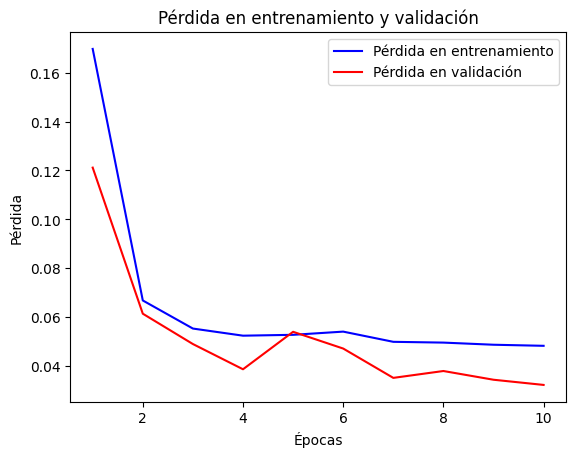

In [107]:
pérdida_entrenamiento = historial.history['loss']
pérdida_validación = historial.history['val_loss']

# Número de épocas
épocas = range(1, len(pérdida_entrenamiento) + 1)

# Graficar las pérdidas
plt.plot(épocas, pérdida_entrenamiento, 'b', label='Pérdida en entrenamiento')
plt.plot(épocas, pérdida_validación, 'r', label='Pérdida en validación')
plt.title('Pérdida en entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [108]:
# Evalúa el modelo en el conjunto de prueba
puntuacion_modelo2 = modelo_v2.evaluate(X_prueba, y_prueba, verbose=1)
print("Puntuación segundo modelo en el conjunto de prueba (MSE):", puntuacion_modelo2)

24/24 [==============================] - 1s 8ms/step - loss: 0.0583
Puntuación segundo modelo en el conjunto de prueba (MSE): 0.05827007070183754


In [109]:
predicciones_v2 = modelo_v2.predict(X_prueba)

24/24 [==============================] - 1s 6ms/step


In [110]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_prueba, predicciones_v2)
mae = mean_absolute_error(y_prueba, predicciones_v2)

print(f"Error Cuadrático Medio segundo modelo (MSE): {mse}")
print(f"Error Absoluto Medio segundo modelo (MAE): {mae}")

Error Cuadrático Medio segundo modelo (MSE): 0.12008411533650987
Error Absoluto Medio segundo modelo (MAE): 0.20371681567260527


Haremos una tercera version del modelo buscando reducir el error MSE y MAE

In [111]:
# Define el modelo mejorado version 3 (modelo_v3)
modelo_v3 = Sequential()

# Primera capa LSTM con dropout
modelo_v3.add(LSTM(units=64, input_shape=(ventana_historica, 1), return_sequences=True))
modelo_v3.add(Dropout(0.2))

# Segunda capa LSTM con dropout
modelo_v3.add(LSTM(units=64, return_sequences=False))
modelo_v3.add(Dropout(0.4))

# # Capa GRU con dropout
# modelo_v3.add(GRU(units=64, return_sequences=False))
# modelo_v3.add(Dropout(0.2))

# # Segunda capa GRU con dropout
# modelo_v3.add(GRU(units=64, return_sequences=False))
# modelo_v3.add(Dropout(0.3))

# Capa de salida
modelo_v3.add(Dense(units=90, activation='linear'))  # 90 días para pronosticar 3 meses

# Optimizador
opt = Adam(learning_rate=0.001)

# Compila el modelo mejorado version 3 (modelo_v3)
modelo_v3.compile(optimizer=opt, loss=Huber(delta=1.0))

# Muestra un resumen del modelo mejorado version 3 (modelo_v3)
modelo_v3.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 90, 64)            16896     
                                                                 
 dropout_33 (Dropout)        (None, 90, 64)            0         
                                                                 
 lstm_29 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_34 (Dropout)        (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 90)                5850      
                                                                 
Total params: 55770 (217.85 KB)
Trainable params: 55770 (217.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [112]:
modelo_v3.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_validacion, y_validacion), epochs=10, batch_size=10, verbose=1)

Epoch 1/10
1531/1531 [==============================] - 22s 12ms/step - loss: 0.2278 - val_loss: 0.1743
Epoch 2/10
1531/1531 [==============================] - 16s 11ms/step - loss: 0.1182 - val_loss: 0.0857
Epoch 3/10
1531/1531 [==============================] - 16s 10ms/step - loss: 0.0888 - val_loss: 0.0775
Epoch 4/10
1531/1531 [==============================] - 17s 11ms/step - loss: 0.0864 - val_loss: 0.0702
Epoch 5/10
1531/1531 [==============================] - 16s 10ms/step - loss: 0.0826 - val_loss: 0.0643
Epoch 6/10
1531/1531 [==============================] - 16s 11ms/step - loss: 0.0811 - val_loss: 0.0699
Epoch 7/10
1531/1531 [==============================] - 16s 10ms/step - loss: 0.0836 - val_loss: 0.0673
Epoch 8/10
1531/1531 [==============================] - 17s 11ms/step - loss: 0.0804 - val_loss: 0.0716
Epoch 9/10
1531/1531 [==============================] - 16s 10ms/step - loss: 0.0801 - val_loss: 0.0567
Epoch 10/10
1531/1531 [==============================] - 16s 11m

In [113]:
# Evalúa el modelo en el conjunto de prueba
puntuacion_modelo3 = modelo_v3.evaluate(X_prueba, y_prueba, verbose=1)
print("Puntuación segundo modelo en el conjunto de prueba (MSE):", puntuacion_modelo3)

24/24 [==============================] - 1s 9ms/step - loss: 0.0684
Puntuación segundo modelo en el conjunto de prueba (MSE): 0.06842830777168274


In [114]:
predicciones_v3 = modelo_v3.predict(X_prueba)

24/24 [==============================] - 1s 7ms/step


In [115]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_prueba, predicciones_v3)
mae = mean_absolute_error(y_prueba, predicciones_v3)

print(f"Error Cuadrático Medio tercer modelo (MSE): {mse}")
print(f"Error Absoluto Medio tercer modelo (MAE): {mae}")

Error Cuadrático Medio tercer modelo (MSE): 0.13948151616066648
Error Absoluto Medio tercer modelo (MAE): 0.24010158419188615


En este caso podemos ver que aun volviendo un poco más complejo el modelo no obtenemos un mejor MSE. Por lo tanto trabajaremos en el batch size y epocas del mejor modelo actual, siendo el modelo_v2.

In [116]:
# Define el modelo mejorado version 1
modelo_v2_reloaded = Sequential()

# Primera capa LSTM con dropout
modelo_v2_reloaded.add(LSTM(units=64, input_shape=(ventana_historica, 1), return_sequences=True))
modelo_v2_reloaded.add(Dropout(0.2))

# Capa GRU con 64 unidades y return_sequences=False
modelo_v2_reloaded.add(GRU(units=64, return_sequences=False))
modelo_v2_reloaded.add(Dropout(0.2))
# # Segunda capa LSTM con dropout
# modelo_v2_reloaded.add(LSTM(units=64, return_sequences=False))
# modelo_v2_reloaded.add(Dropout(0.3))

modelo_v2_reloaded.add(Dense(units=90, activation='linear'))  # 90 días para pronosticar 3 meses

# Optimizador
opt = Adam(learning_rate=0.001)

# Compila el modelo mejorado version 1
modelo_v2_reloaded.compile(optimizer=opt, loss=Huber(delta=1.0))

# Muestra un resumen del modelo mejorado version 1
modelo_v2_reloaded.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 90, 64)            16896     
                                                                 
 dropout_35 (Dropout)        (None, 90, 64)            0         
                                                                 
 gru_11 (GRU)                (None, 64)                24960     
                                                                 
 dropout_36 (Dropout)        (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 90)                5850      
                                                                 
Total params: 47706 (186.35 KB)
Trainable params: 47706 (186.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [117]:
modelo_v2_reloaded.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_validacion, y_validacion), epochs=5, batch_size=1, verbose=1)

Epoch 1/5
15310/15310 [==============================] - 166s 11ms/step - loss: 0.0974 - val_loss: 0.0437
Epoch 2/5
15310/15310 [==============================] - 158s 10ms/step - loss: 0.0552 - val_loss: 0.0368
Epoch 3/5
15310/15310 [==============================] - 162s 11ms/step - loss: 0.0523 - val_loss: 0.0361
Epoch 4/5
15310/15310 [==============================] - 166s 11ms/step - loss: 0.0509 - val_loss: 0.0332
Epoch 5/5
15310/15310 [==============================] - 173s 11ms/step - loss: 0.0502 - val_loss: 0.0325


In [118]:
# Evalúa el modelo en el conjunto de prueba
puntuacion_modelo2 = modelo_v2_reloaded.evaluate(X_prueba, y_prueba, verbose=1)
print("Puntuación segundo modelo en el conjunto de prueba (MSE):", puntuacion_modelo2)

24/24 [==============================] - 1s 8ms/step - loss: 0.0562
Puntuación segundo modelo en el conjunto de prueba (MSE): 0.056162115186452866


In [119]:
predicciones_v2 = modelo_v2_reloaded.predict(X_prueba)

24/24 [==============================] - 1s 6ms/step


In [120]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_prueba, predicciones_v2)
mae = mean_absolute_error(y_prueba, predicciones_v2)

print(f"Error Cuadrático Medio segundo modelo (MSE): {mse}")
print(f"Error Absoluto Medio segundo modelo (MAE): {mae}")

Error Cuadrático Medio segundo modelo (MSE): 0.11545096244294706
Error Absoluto Medio segundo modelo (MAE): 0.20399948848458918


Luego de realizar todos estos cambios de arquitecturas de modelo, parametros e híperparametros por lo que de momento el modelo final que estaremos utilizando será la versión 2 del mismo. Ahora graficaremos las predicciones vs los valores reales.

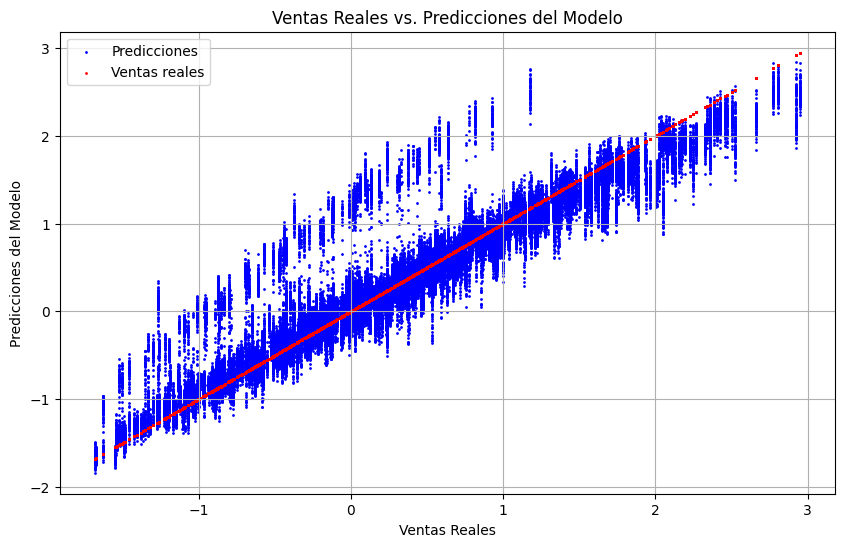

In [125]:
# Crear un gráfico de dispersión (scatter plot)
plt.figure(figsize=(10, 6))
plt.scatter(y_prueba, predicciones_v2, c='blue', label='Predicciones',s=1)  # Pintar las predicciones de azul con marcadores de "x"
plt.scatter(y_prueba, y_prueba, c='red', label='Ventas reales',s=1)  # Pintar los valores reales de rojo con marcadores de "o"
plt.xlabel('Ventas Reales')
plt.ylabel('Predicciones del Modelo')
plt.title('Ventas Reales vs. Predicciones del Modelo')
plt.legend()
plt.grid(True)

plt.show()

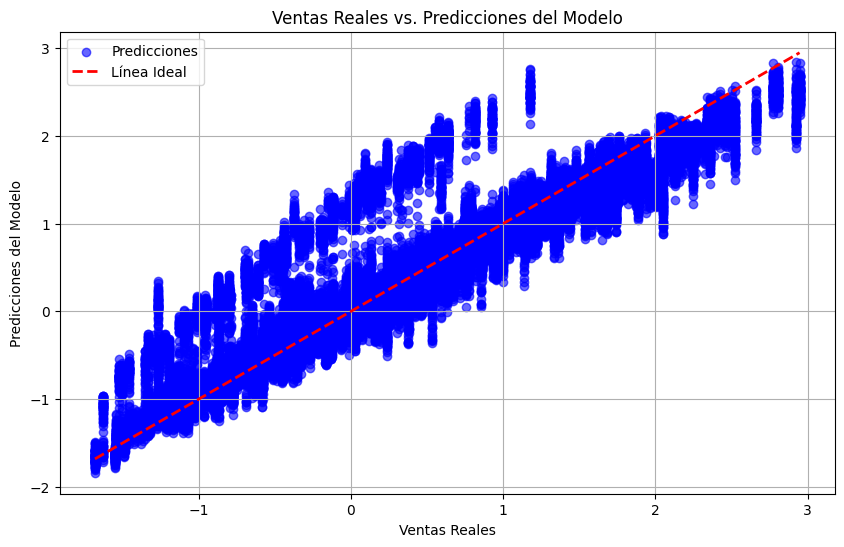

In [128]:
plt.figure(figsize=(10, 6))
plt.scatter(y_prueba, predicciones_v2, c='blue', label='Predicciones', marker='o', alpha=0.6)
plt.plot([np.min(y_prueba), np.max(y_prueba)], [np.min(y_prueba), np.max(y_prueba)], linestyle='--', color='red', linewidth=2, label='Línea Ideal')
plt.xlabel('Ventas Reales')
plt.ylabel('Predicciones del Modelo')
plt.title('Ventas Reales vs. Predicciones del Modelo')
plt.legend()
plt.grid(True)

plt.show()

Ahora en cuanto a temas de interpretabilidad del modelo con SHAP

In [137]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 5.9 MB/s eta 0:00:00


In [143]:
modelo_v2

In [147]:
import shap
explainer = shap.Explainer(modelo_v2, masker=shap.maskers.Independent)

In [151]:
shap_values = explainer.shap_values(X_entrenamiento)


TypeError: ignored

In [ ]:
shap.summary_plot(shap_values, features=X_entrenamiento, show=False)